# Greenhouse Model

## Import dependencies and data

In [18]:
# import dependencies

import time
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

In [19]:
from data_funcs import k_fold_data_validation

In [907]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
results_path = home_path + '\\nn_models\\results\\'

# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

In [908]:
# define data specs
k_frac = 0.05
m = 5
t_steps = 1
n_steps = 6

# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
    #('temperatures', 'TA01_GT401_GM401_scaled'),
    #('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output')
]

## Get data for all folds

In [910]:
version = 1
k_idx = 18

In [911]:
# get test data
_, test_tup, _, col_params = k_fold_data_validation(
    data=data.copy(), 
    k_idx=k_idx, 
    k_frac=k_frac, 
    m=m, 
    cols=cols, 
    t_steps=t_steps, 
    n_steps=n_steps,
    setpoint=True,
    shuffle=False
)

# extract test targets
(sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, _) = test_tup
    

### Get model

In [912]:
from networks import feedForwardNeuralNetwork, recurrentNeuralNetwork

In [913]:
model_name = 'rnn_v{}_k{}'.format(version, k_idx)
load_path = results_path + 'RNN\\' + model_name + '.pickle'

with open(load_path, 'rb') as fo:
    results = pickle.load(fo)

In [914]:
k1 = 7
k2 = 1
M = 32
seed = 1

model = recurrentNeuralNetwork(
    k1=k1,
    k2=k2,
    m=M,
    seed=seed
)

model.weights = results['weights']

## Approximation of $\phi$

In [915]:
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

In [916]:
k = 10
#setpoint = 20
penalty = 0.0

In [917]:
def grid_estimation(seq, k, col_params, model):
    
    ta01_mean = col_params[('state', 'TA01_output')]['mean']
    ta01_std = col_params[('state', 'TA01_output')]['std']
    ta02_mean = col_params[('state', 'TA02_output')]['mean']
    ta02_std = col_params[('state', 'TA02_output')]['std']
    
    ta01 = (np.linspace(0, 100, k) - ta01_mean) / ta01_std
    ta02 = (np.linspace(0, 100, k) - ta02_mean) / ta02_std
    
    seqs = []
    
    for i in range(k):
        for j in range(k):
            new_seq = seq.copy()
            new_seq[-1, -2] = ta01[j]
            new_seq[-1, -1] = ta02[i]
            
            seqs.append(new_seq)
    
    return seqs

In [918]:
temp_mean, temp_std, _, _ = col_params[('temperatures', 'TA01_GT10X_GM10X')].values()
temp_dc_mean, temp_dc_std, _, _ = col_params[('temperatures', 'TA01_GT401_GM401')].values()
temp_out_mean, temp_out_std, _, _ = col_params[('temperatures', 'DC_GT301_damped')].values()

ta01_mean, ta01_std, _, _ = col_params[('state', 'TA01_output')].values()
ta02_mean, ta02_std, _, _ = col_params[('state', 'TA02_output')].values()

### Flow optimization

In [959]:
k = 100
penalty = 0.005
setpoint = (20 - temp_mean) / temp_std

In [960]:
ex_preds = []
ta01_flows = []
ta02_flows = []

seqs_masked = sequences_masked.copy()

# temp = temps_t_test[:1]

for idx, (seq, temp, target) in enumerate(zip(seqs_masked, temps_t_test, targets_test)):
    # get all sequences and predictions
    seqs = grid_estimation(seq, k, col_params, model)
    preds, _ = model.predict(np.stack(seqs), np.ones((k*k, 1)) * temp[0], train=False)

    # create k by k grid w. setpoint distances
    output_grid = np.abs(preds.reshape((k, k)) - target[0])#setpoint

    # interpolate and cast grid to [0, 100]x[0, 100]
    grid = RegularGridInterpolator(
            points=(np.linspace(0, 100, k), np.linspace(0, 100, k)),
            values=output_grid
    )
    
    def obj(x):
        ta01_new, ta02_new = x
        grid = RegularGridInterpolator(
            points=(np.linspace(0, 100, k), np.linspace(0, 100, k)),
            values=output_grid.T + penalty * ((ta01 - ta01_new)**2 + (ta02 - ta02_new)**2)
        )

        return grid([ta01_new, ta02_new])

    opt = minimize(
        fun=obj, 
        x0=(50, 50), 
        method='Nelder-Mead', 
        bounds=[(0, 99), (0, 99)],
        options={'disp': False}
    )

    ta01, ta02 = opt.x 
    
    ta01_flows.append(ta01)
    ta02_flows.append(ta02)
    
    new_seq = seq.copy()
    new_seq[-1, -2] = (ta01 - ta01_mean) / ta01_std
    new_seq[-1, -1] = (ta02 - ta02_mean) / ta02_std
    
    temp_pred, _ = model.predict(new_seq[np.newaxis, :], temp[np.newaxis, :], train=False)
    ex_preds.append(temp_pred)

#     # adjust sequences!!!!
#     try:
#         for t in range(1, n_steps-t_steps):
#             seqs_masked[idx+t, n_steps-t_steps-t, -2] = (ta01 - ta01_mean) / ta01_std 
#             seqs_masked[idx+t, n_steps-t_steps-t, -1] = (ta02 - ta02_mean) / ta02_std
#     except IndexError:
#         break
    

## Plot difference in $\phi$

In [961]:
plot_path = home_path + '\\nn_models\\plots\\'

In [962]:
# set plot defaults
plt.rcdefaults()

font = {
    'family' : 'arial',
    'weight' : 'normal',
    'size'   : 14
}

tit_font = {
    'family' : 'arial',
    'weight' : 'bold',
    'size'   : 16
}

suptit_font = {
    'family' : 'arial',
    'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)

In [963]:
n = 2000

In [964]:
ta01_actual = sequences_test[:n, -1, -2] * ta01_std + ta01_mean
ta02_actual = sequences_test[:n, -1, -1] * ta02_std + ta02_mean

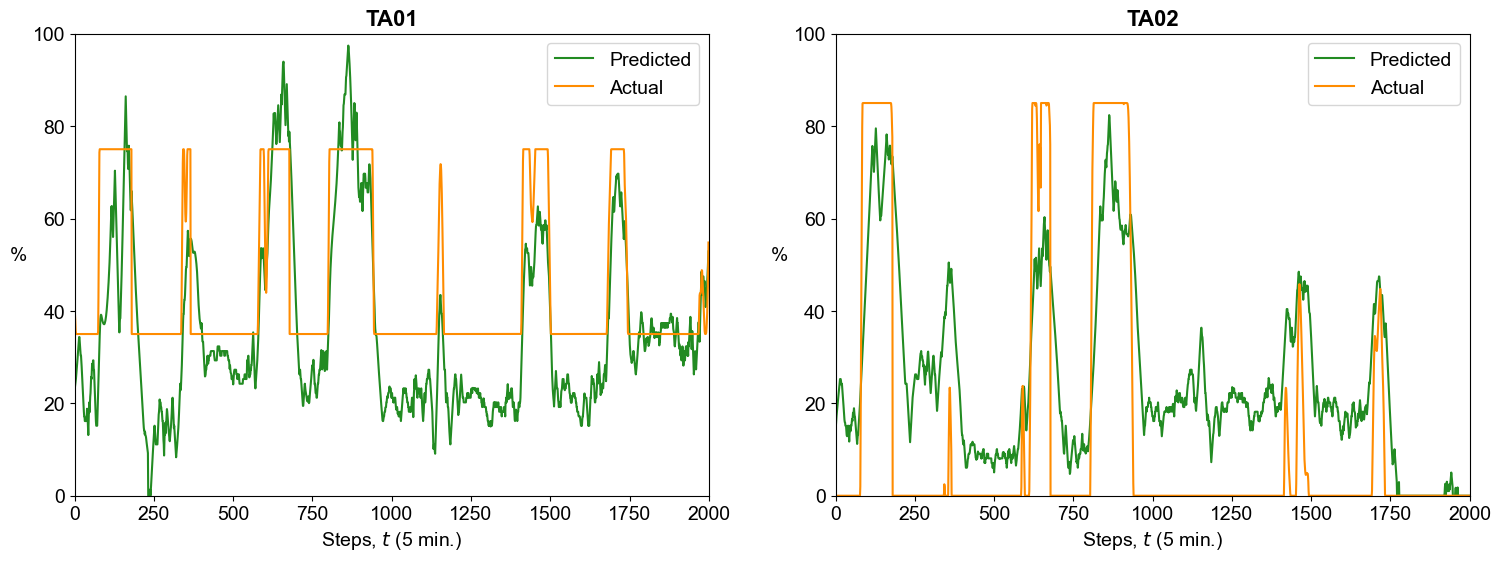

In [965]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1.plot(ta01_flows[:n], color='forestgreen', label='Predicted')
ax1.plot(ta01_actual, color='darkorange', label='Actual')
ax1.set_xlim(0, n)
ax1.set_ylim(0, 100)
ax1.set_xlabel('Steps, $t$ (5 min.)')
ax1.set_ylabel('%', rotation=0, labelpad=10)
ax1.legend(loc='upper right')
ax1.set_title('TA01', **tit_font)

ax2.plot(ta02_flows[:n], color='forestgreen', label='Predicted')
ax2.plot(ta02_actual, color='darkorange', label='Actual')
ax2.set_xlim(0, n)
ax2.set_ylim(0, 100)
ax2.set_xlabel('Steps, $t$ (5 min.)')
ax2.set_ylabel('%', rotation=0, labelpad=10)
ax2.legend(loc='upper right')
ax2.set_title('TA02', **tit_font)

plt.savefig(plot_path + 'flow_comp.png', dpi=200, bbox_inches='tight')

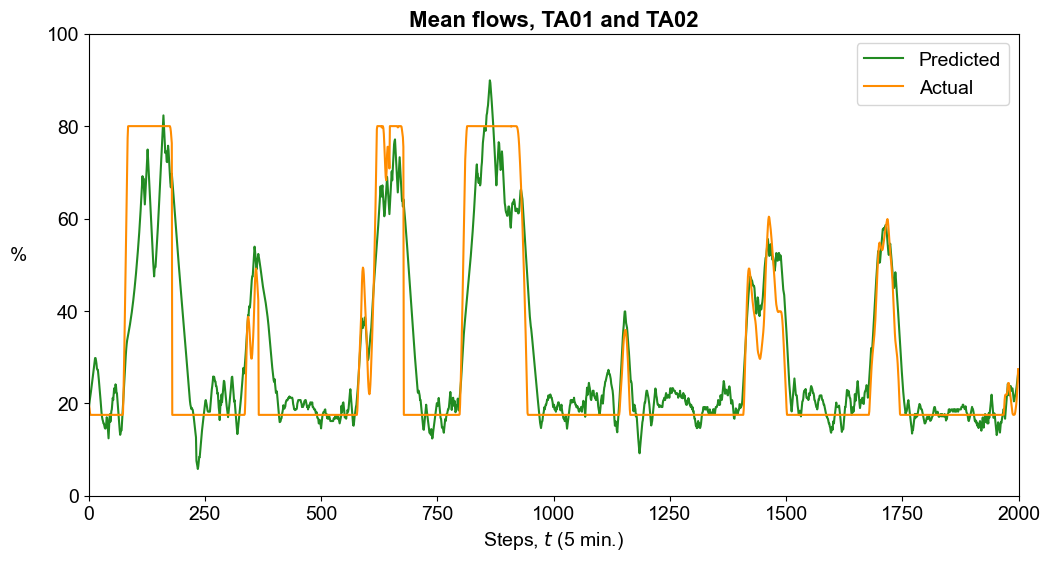

In [979]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

mean_actual = (ta01_actual + ta02_actual) / 2
mean_predicted = (np.array(ta01_flows[:n]) + np.array(ta02_flows[:n])) / 2


ax.plot(mean_predicted, color='forestgreen', label='Predicted')
ax.plot(mean_actual, color='darkorange', label='Actual')
ax.set_xlim(0, n)
ax.set_ylim(0, 100)
ax.set_ylabel('%', rotation=0, labelpad=20)
ax.set_xlabel('Steps, $t$ (5 min.)')
ax.legend(loc='upper right')
ax.set_title('Mean flows, TA01 and TA02', **tit_font)

plt.savefig(plot_path + 'flow_comp_mean.png', dpi=200)